# GO analysis

## GO
The [Gene Ontology database](http://geneontology.org/) contains many hierarchical annotation terms related to three kinds of biological informations:
1. BP: Biological process
2. MF: Molecular function
3. CC: Cellular component
Each term is associated with a gene set, the gene sets have the same hierarchy as the annotation set.

## GO analysis input
To perform GO enrichment analysis, you need 
1. The GO database (in obo format, but you don't really need to know what it is, it's just a file), which contains all the terms and their associated gene sets
2. Your gene set of interests, e.g. a list of DEG identified from a pairwise comparison
3. Background gene set, usually, use all protein coding genes

GO analysis is just performing Fisher's exact test on each GO term, asking whether this GO term's gene set has more overlap with your GOI set than with the background gene set.

## The most simple way to run GO analysis
- Use the STRING database (https://string-db.org/), it not only do GO for you, but also run many other analysis
- Try some other gene set annotation tool, such as [phenolyzer](http://phenolyzer.wglab.org/)
- This notebook is just showing you some more details of GO analysis using python package GOATools

## Install goatools first

```shell
conda install goatools
```

In [1]:
import pandas as pd
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.test_data.genes_NCBI_10090_ProteinCoding import GENEID2NT as GeneID2nt_mus
from goatools.test_data.genes_NCBI_9606_ProteinCoding import GENEID2NT as GeneID2nt_human
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj

## Load Gene Meta

In [2]:
gene_meta = pd.read_csv('./gene_metadata.csv.gz', index_col='gene_id')

# get a dict for later annotating gene name
gene_id_base_to_name = {gene_id.split('.')[0]: gene_name for gene_id, gene_name in gene_meta['gene_name'].items()}

gene_meta.head()

,chrom,source,feature,start,end,strand,gene_type,gene_name,level,mgi_id,havana_gene,tag
gene_id,,,,,,,,,,,,
ENSMUSG00000102693.1,chr1,HAVANA,gene,3073253,3074322,+,TEC,4933401J01Rik,2,MGI:1918292,OTTMUSG00000049935.1,NaN
ENSMUSG00000064842.1,chr1,ENSEMBL,gene,3102016,3102125,+,snRNA,Gm26206,3,MGI:5455983,NaN,NaN
ENSMUSG00000051951.5,chr1,HAVANA,gene,3205901,3671498,-,protein_coding,Xkr4,2,MGI:3528744,OTTMUSG00000026353.2,NaN
ENSMUSG00000102851.1,chr1,HAVANA,gene,3252757,3253236,+,processed_pseudogene,Gm18956,1,MGI:5011141,OTTMUSG00000049958.1,pseudo_consens
ENSMUSG00000103377.1,chr1,HAVANA,gene,3365731,3368549,-,TEC,Gm37180,2,MGI:5610408,OTTMUSG00000049960.1,NaN


### ID map between entrez and ensembl
The GO dataset we used here using NCBI Entrez gene id, while GENCODE uses ENSEMBL ID, they are two different id systems, but we can use the file below to match them. Note that not all the gene ID in GENCODE can be found in Entrez, this is fine, because usually those genes are relatively novel so not all database has record for that. Most important protein coding genes should be able to be included in both

This file is downloaded from here, but I only took rows related to human and mouse so its much smaller for you to download: ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/

In [3]:
entrez_ensembl_idmap_df = pd.read_csv(
    'EntrezID_ENSEMBL_ID.human_and_mouse.csv.gz')
ensembl_to_entrez_id_dict = entrez_ensembl_idmap_df.set_index(
    'Ensembl_gene_identifier')['GeneID'].to_dict()
entrez_to_ensembl_id_dict = {
    v: k
    for k, v in ensembl_to_entrez_id_dict.items()
}

In [4]:
gene_meta['EntrezID'] = gene_meta.index.str.split('.').str[0].map(ensembl_to_entrez_id_dict)
print(f'{gene_meta.shape[0]} input genes')
gene_meta = gene_meta[~gene_meta['EntrezID'].isna()].copy()
print(f'{gene_meta.shape[0]} genes have Entrez ID, we will only use these genes for GO analysis')

55385 input genes
31242 genes have Entrez ID, we will only use these genes for GO analysis


## Set up GO

**IMPORTANT: Remember to change taxids into 9606 for human. 10090 is mouse tax id.**

This cell will download GO database automatically, it will take sometime

In [5]:
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()

# this is the whole GO database loaded into memory
obodag = GODag("go-basic.obo")

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[10090])  # change to 9606 for human
# Get namespace2association where: 
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated mouse genes".format(NS=nspc, N=len(id2gos)))

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2020-06-01) 47,233 GO Terms
HMS:0:00:04.551457 378,417 annotations, 24,283 genes, 18,403 GOs, 1 taxids READ: gene2go 
MF 16,873 annotated mouse genes
CC 19,029 annotated mouse genes
BP 18,173 annotated mouse genes


## create GO analysis object

In [6]:
# background genes, use all protein coding genes

bg_genes = list(GeneID2nt_mus.keys())

#IMPORTANT: use this for HUMAN
# bg_genes = list(GeneID2nt_human.keys())

In [7]:
goeaobj = GOEnrichmentStudyNS(
        bg_genes, # List of mouse protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 61% 17,108 of 28,212 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 65% 18,353 of 28,212 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 58% 16,497 of 28,212 population items found in association


## Run GO analysis for each DEG results

In [8]:
deg_results = pd.read_csv('./TotalDEG.csv.gz')

# add a column indicating log2FC sign
deg_results['log2fc_direction'] = deg_results['log2FoldChange'] > 0

In [9]:
deg_dict = {}

for (lg2fc_direction, cluster_a, cluster_b), sub_df in deg_results.groupby(['log2fc_direction', 'cluster_a', 'cluster_b']):
    if lg2fc_direction:
        # log2fc > 0, cluster_a > cluster_b
        name = f'{cluster_a} high - {cluster_b} low'
    else:
        name = f'{cluster_b} high - {cluster_a} low'
    
    print(name)
    # sub_df contain all DEGs, I select those that have entrez_id
    print(f'{sub_df.shape[0]} total DEG from DESeq2.')
    select_genes = gene_meta.reindex(sub_df['gene_id'].values)['EntrezID'].dropna().astype(int).tolist()
    print(f'{len(select_genes)} DEGs have entrez id.')
    print()
    
    deg_dict[name] = select_genes

E14.5 high - E10.5 low
1504 total DEG from DESeq2.
1444 DEGs have entrez id.

P0 high - E10.5 low
2351 total DEG from DESeq2.
2251 DEGs have entrez id.

P0 high - E14.5 low
265 total DEG from DESeq2.
258 DEGs have entrez id.

E10.5 high - E14.5 low
605 total DEG from DESeq2.
529 DEGs have entrez id.

E10.5 high - P0 low
1169 total DEG from DESeq2.
1043 DEGs have entrez id.

E14.5 high - P0 low
222 total DEG from DESeq2.
210 DEGs have entrez id.



## Run GO

In [11]:
# 'p_' means "pvalue". 'fdr_bh' is the multipletest method we are currently using.
for name, genes in deg_dict.items():
    print(name)
    goea_results_all = goeaobj.run_study(list(genes))
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    goeaobj.wr_tsv(f"GO/{name}.GO.tsv", goea_results_sig)
    plot_results(f"GO/{name}.GO{{NS}}.png", goea_results_sig)
    
    # add more gene info
    sig_go_df = pd.read_csv(f"GO/{name}.GO.tsv", sep='\t', index_col=0)
    sig_go_df['study_items'] = sig_go_df['study_items'].fillna('')
    sig_go_df['gene_ids'] = sig_go_df['study_items'].apply(lambda i: ','.join(
        [entrez_to_ensembl_id_dict[int(g)] for g in i.split(',') if g != '']))
    sig_go_df['gene_names'] = sig_go_df['gene_ids'].apply(lambda i: ','.join(
        [gene_id_base_to_name[g] for g in i.split(',') if g != '']))
    sig_go_df.to_csv(f"GO/{name}.GO.tsv", sep='\t')

E14.5 high - E10.5 low

Run BP Gene Ontology Analysis: current study set of 1444 IDs ... 87%  1,213 of  1,387 study items found in association
 96%  1,387 of  1,444 study items found in population(28212)
Calculating 12,420 uncorrected p-values using fisher_scipy_stats
  12,420 GO terms are associated with 17,108 of 28,212 population items
   3,699 GO terms are associated with  1,213 of  1,444 study items
  METHOD fdr_bh:
     323 GO terms found significant (< 0.05=alpha) (317 enriched +   6 purified): statsmodels fdr_bh
     891 study items associated with significant GO IDs (enriched)
      22 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 1444 IDs ... 93%  1,287 of  1,387 study items found in association
 96%  1,387 of  1,444 study items found in population(28212)
Calculating 1,751 uncorrected p-values using fisher_scipy_stats
   1,751 GO terms are associated with 18,353 of 28,212 population items
     607 GO terms are a

  177 usr 612 GOs  WROTE: GO/E10.5 high - E14.5 low.GOBP.png
   24 usr  39 GOs  WROTE: GO/E10.5 high - E14.5 low.GOCC.png
   34 usr  85 GOs  WROTE: GO/E10.5 high - E14.5 low.GOMF.png
E10.5 high - P0 low

Run BP Gene Ontology Analysis: current study set of 1043 IDs ... 93%    943 of  1,009 study items found in association
 97%  1,009 of  1,043 study items found in population(28212)
Calculating 12,420 uncorrected p-values using fisher_scipy_stats
  12,420 GO terms are associated with 17,108 of 28,212 population items
   3,633 GO terms are associated with    943 of  1,043 study items
  METHOD fdr_bh:
     373 GO terms found significant (< 0.05=alpha) (371 enriched +   2 purified): statsmodels fdr_bh
     744 study items associated with significant GO IDs (enriched)
      15 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 1043 IDs ... 96%    969 of  1,009 study items found in association
 97%  1,009 of  1,043 study items found 

## Plot (example)

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [13]:
dec_go = pd.read_csv('GO/E10.5 high - P0 low.GO.tsv', sep='\t', index_col=0)
dec_go['-lgp'] = -np.log10(dec_go['p_fdr_bh'])
dec_go.sort_values('-lgp', ascending=False, inplace=True)

inc_go = pd.read_csv('GO/P0 high - E10.5 low.GO.tsv', sep='\t', index_col=0)
inc_go['-lgp'] = -np.log10(inc_go['p_fdr_bh'])
inc_go.sort_values('-lgp', ascending=False, inplace=True)


In [16]:
# the result table not only contain GO terms, but also individual genes
dec_go.head()

,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items,gene_ids,gene_names,-lgp
# GO,,,,,,,,,,,,,
GO:0005634,CC,e,nucleus,544/1009,5818/28212,4.866616e-125,5,544,8.521445e-122,"11545, 11694, 11695, 11799, 11863, 11908, 1192...","ENSMUSG00000026496,ENSMUSG00000014603,ENSMUSG0...","Parp1,Alx3,Alx4,Birc5,Arnt,Atf1,Atm,Neurog2,Ba...",121.069487
GO:0007049,BP,e,cell cycle,164/1009,620/28212,8.572576e-96,2,164,1.064714e-91,"11799, 11920, 12189, 12190, 12235, 12236, 1231...","ENSMUSG00000017716,ENSMUSG00000034218,ENSMUSG0...","Birc5,Atm,Brca1,Brca2,Bub1,Bub1b,Aspm,Ccna2,Cc...",90.972767
GO:0005654,CC,e,nucleoplasm,324/1009,2950/28212,7.660975e-82,2,324,6.707183e-79,"11409, 11545, 11695, 11828, 11863, 11908, 1192...","ENSMUSG00000029545,ENSMUSG00000026496,ENSMUSG0...","Acads,Parp1,Alx4,Aqp3,Arnt,Atf1,Atm,Blm,Bnc1,B...",78.173460
GO:0051301,BP,e,cell division,112/1009,378/28212,9.680026e-71,2,112,6.011296e-67,"11799, 12235, 12236, 12316, 12428, 12442, 1244...","ENSMUSG00000017716,ENSMUSG00000027379,ENSMUSG0...","Birc5,Bub1,Bub1b,Aspm,Ccna2,Ccnb2,Ccnd1,Ccnd3,...",66.221032
GO:0003677,MF,e,DNA binding,218/1009,1732/28212,7.381387e-63,4,218,3.084682e-59,"11545, 11694, 11695, 11863, 11908, 11920, 1192...","ENSMUSG00000026496,ENSMUSG00000014603,ENSMUSG0...","Parp1,Alx3,Alx4,Arnt,Atf1,Atm,Neurog2,Blm,Bnc1...",58.510790


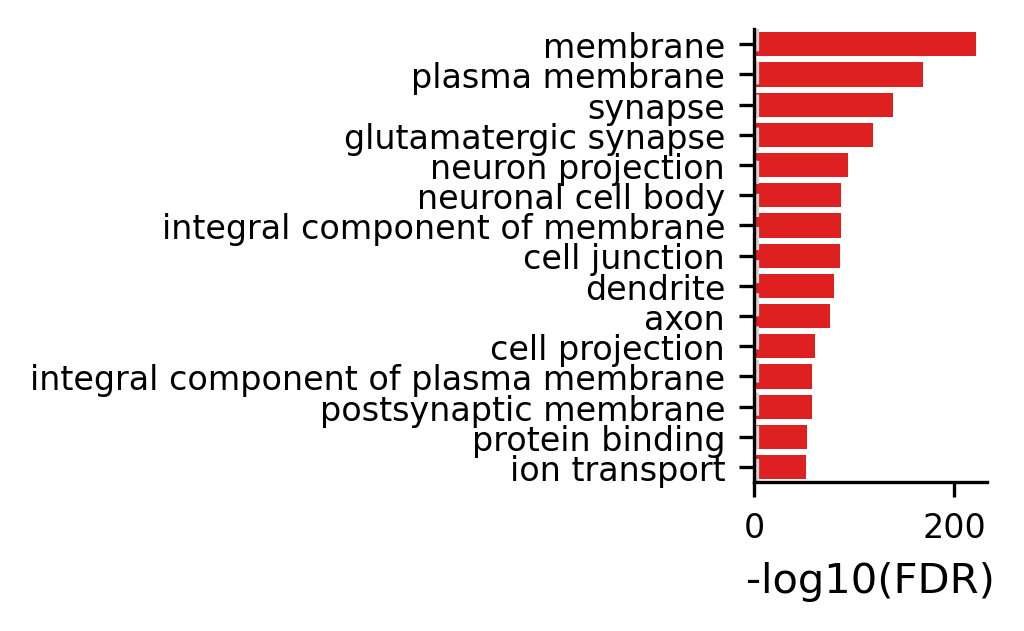

In [22]:
fig, ax = plt.subplots(figsize=(1, 2), dpi=300)
sns.barplot(data=inc_go.iloc[:15], x='-lgp', y='name', color='red')

ax.axvline(-np.log10(0.01), color='lightgray', linestyle='--')
sns.despine(ax=ax)
ax.set(xlabel='-log10(FDR)', ylabel='')
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
# fig.savefig('IncGO.pdf')

## Suggestions on plotting GO results
- If your GO terms are too broad, you can manually select any specific terms to make it more meaningful. For example, the GO term membrane contains thousands of genes related to cell membrane, its probably meaningless to say your GOI is relate to membrane... its too broad. Postsynaptic membrane is much better than mambrane, since its a more specific term.
- GO terms do not tell you too much detail biology information, let along being the gold standard as biological evidence. It just give you a weak information that potentially help you guess what biological process is involved. Eventually, you neet to focus on specific genes. Therefore, if a GO term is significant, it's always good to check which exact gene(s) in this term are overlapping with your DEG results, does that gene has particular interesting story related to your experiment. You can also add several gene names to this barplot, to make it more meaningful.
- The gene information can be found in the go results table

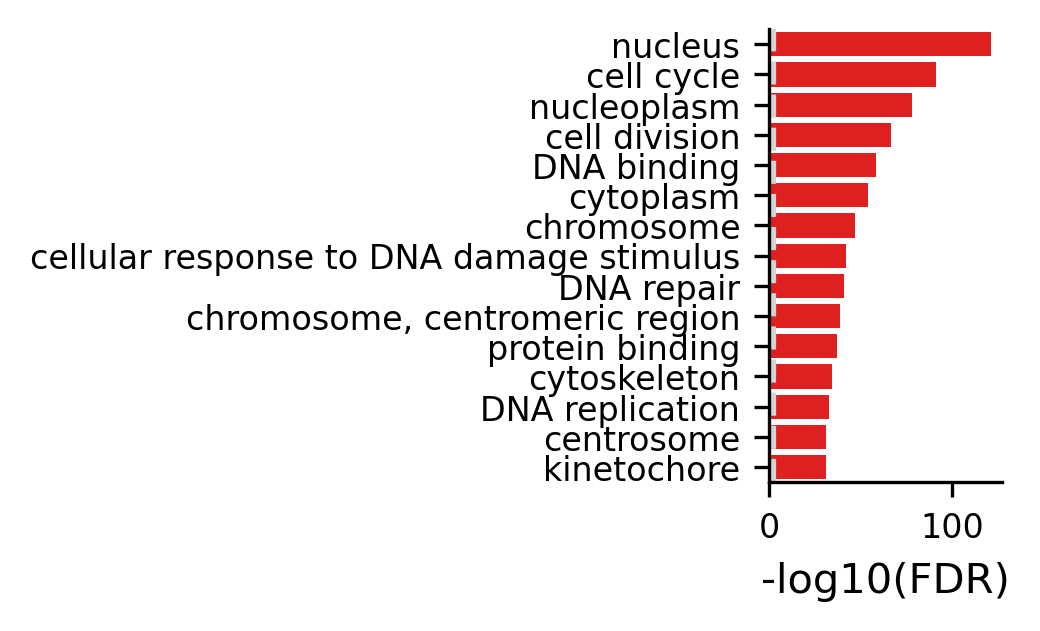

In [23]:
fig, ax = plt.subplots(figsize=(1, 2), dpi=300)
sns.barplot(data=dec_go.iloc[:15], x='-lgp', y='name', color='red')

ax.axvline(-np.log10(0.01), color='lightgray', linestyle='--')
sns.despine(ax=ax)
ax.set(xlabel='-log10(FDR)', ylabel='')
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
# fig.savefig('IncGO.pdf')